# Study of COVID data in the US (based on NYT data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
sns.set()
import time
import math

In [2]:
# matplotlib.style.use('seaborn-whitegrid')

## Get NYT data and prepare it

In [247]:
# Read from NYT data CSV
df_ = pd.read_csv('us-states.csv')

In [248]:
# Make date string a proper datetime data type
df_['date']=df_['date'].apply(lambda x:pd.Timestamp(x))
df_.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [249]:
# Add states abbreviations
df_abb = pd.read_csv('other_input/us-states-abbreviations.csv')
df = pd.merge(left=df_, right=df_abb, on='state', how='outer')
df.head()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
0,2020-01-21,Washington,53,1,0,Wash.,WA
1,2020-01-22,Washington,53,1,0,Wash.,WA
2,2020-01-23,Washington,53,1,0,Wash.,WA
3,2020-01-24,Washington,53,1,0,Wash.,WA
4,2020-01-25,Washington,53,1,0,Wash.,WA


In [250]:
last_date = df.date.max()
last_date

Timestamp('2020-07-28 00:00:00')

## US States ranked by number of cases

In [6]:
# States with most cases (on last available date)
df_ti = df[df['date'] == last_date].sort_values(by='cases', ascending=False)
df_ti.head()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
562,2020-07-28,California,6,474951,8716,Calif.,CA
1889,2020-07-28,Florida,12,441969,6116,Fla.,FL
2039,2020-07-28,New York,36,417591,32333,N.Y.,NY
1269,2020-07-28,Texas,48,412744,6515,Tex.,TX
2782,2020-07-28,New Jersey,34,182215,15825,N.J.,NJ


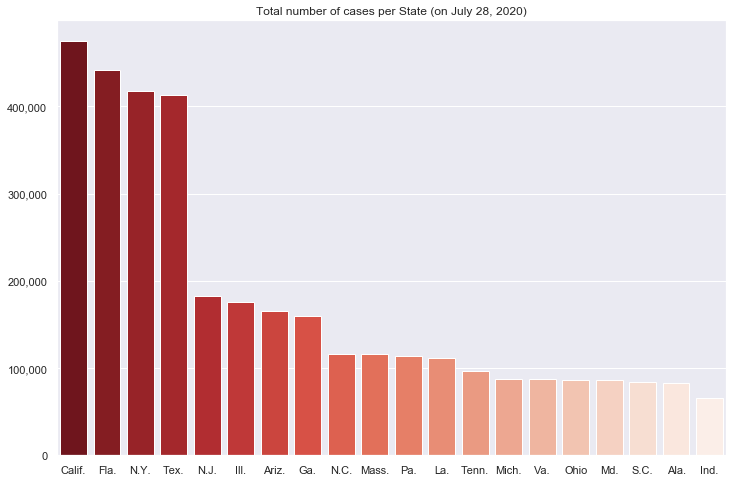

In [8]:
# Plot the States ranked by number of cases
fig, ax = plt.subplots(figsize=(12, 8))
number_of_states_to_visualize = 20
df_ti_p = df_ti.head(number_of_states_to_visualize).copy()
x = df_ti_p['Abbreviation']
y = df_ti_p['cases']
# bar_container = ax.bar(x=x, height=y)
sns.barplot(x=x, y=y, palette='Reds_r', ax=ax)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
ax.get_xaxis().label.set_visible(False)
ax.get_yaxis().label.set_visible(False)
out = ax.set_title(f'Total number of cases per State (on {last_date.strftime("%B %d, %Y")})')

In [ ]:
# fig.savefig(f'output_visuals/Total_number_of_Cases_{last_date.strftime("%B_%d_%Y")}.png')

## Evolution throught time of the number of cases per state

In [12]:
# Number of states considered (among top impacted)
nb_states_time_plot = 10
df_states_considered = df_ti['state'].head(nb_states_time_plot)
# index on the most impacted states only
boolean_index = df['state'].isin(df_states_considered)
# df time plot
df_tp = df[boolean_index]
df_tp.tail()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
2778,2020-07-24,New Jersey,34,180265,15765,N.J.,NJ
2779,2020-07-25,New Jersey,34,180778,15776,N.J.,NJ
2780,2020-07-26,New Jersey,34,181283,15787,N.J.,NJ
2781,2020-07-27,New Jersey,34,181732,15804,N.J.,NJ
2782,2020-07-28,New Jersey,34,182215,15825,N.J.,NJ


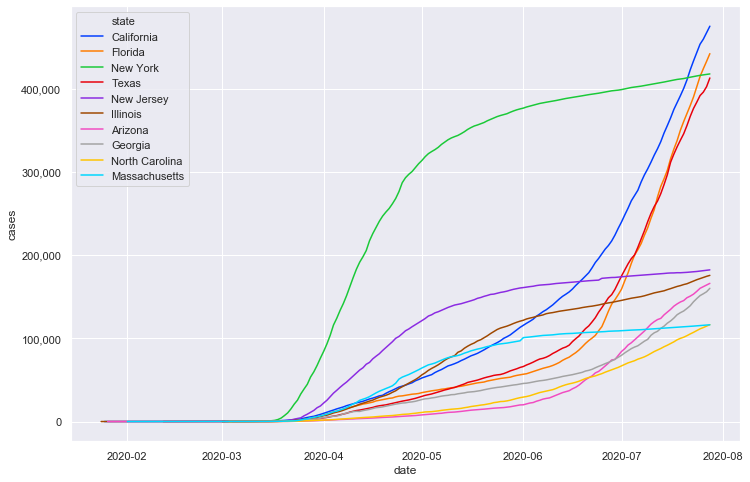

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='date', y='cases', hue='state', palette='bright', hue_order=df_states_considered,
             ax=ax, data=df_tp)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))

TAKE-AWAY: New York is flatening, but California/Florida/Texas are experiencing an exponential growth of the number of cases.

In [15]:
# fig.savefig(f'output_visuals/Evolution_total_number_of_cases_through_time_' \
#             f'{last_date.strftime("%B_%d_%Y")}.png')

## Face Masks Effectiveness (study per US county)

In [16]:
# Initiate dfm dataframe to do that mask correlation analysis (cases per county through time)
dfm0 = pd.read_csv('us-counties.csv')
# Cast date into proper datetime objects
dfm0['date'] = dfm0['date'].apply(lambda x: pd.Timestamp(x))
dfm0.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [17]:
len(dfm0)

379550

In [91]:
# Inital number of counties from the input file
nb_fips0 = len(set(dfm0.fips))
print(f'The initial number of counties out of the input file is: {nb_fips0}')

The initial number of counties out of the input file is: 3187


#### Side analysis on why fips should be used (and not only the county name which is not unique in US)

In [81]:
# County name and its fips
dfcf = dfm0.loc[:, ['county', 'fips', 'state']].drop_duplicates()
dfcf.head(1)

,county,fips,state
0,Snohomish,53061,Washington


In [82]:
dfcf1 = dfcf.groupby(by='county').count()
dfcf2 = dfcf1[dfcf1.fips > 1]
dfcf2.head(2)

,fips,state
county,,
Adair,4,4
Adams,12,12


In [83]:
avg_county_repeat = np.round(dfcf2.state.mean(), 1)

In [84]:
dfcf[dfcf.county=='Adair']

,county,fips,state
3388,Adair,19001,Iowa
8892,Adair,29001,Missouri
11906,Adair,40001,Oklahoma
33965,Adair,21001,Kentucky


In [79]:
print(f'There are {len(dfcf2)} counties in the US whose same county name is also used \n'
      f'in an average of {avg_county_repeat - 1} other states')

There are 428 counties in the US whose same county name is also used 
in an average of 3.0 other states


For example, the 'Adair' county name is used in the state of Iowa, but also in 3 other states: 'Missouri', 'Oklahoma' and 'Kentucky'.

###  Prepare and standardize the counties fips codes for use as a key for table merging

In [85]:
# fips dtype
# dfm0.fips.dtype

In [19]:
def fipsAsString(fips_float):
    """Converts a fips code read as float into a formatted string"""
    try:
        fips_int = int(fips_float)
        fips_str = str(fips_int)
    except:
        fips_str = 'NA'
    return fips_str

In [86]:
# If the fips column is a flaot, convert it to a string (for use as a key later)
def convertFromTypeToStr(df, from_type):
    """Converts a dataframe (Series) fips column data type into a formatted string"""
    if df.dtype == from_type:
        df = df.apply(fipsAsString)
        df = df.astype('str')
        print('df converted to string')
    else:
        print(f'df dtype already: {df.dtypes}')
    return df

In [87]:
dfm0['fips'] = convertFromTypeToStr(df=dfm0['fips'], from_type=np.float64)
# fips are now properly formatted as strings in the main dfm
dfm0.head(1)

df dtype already: object


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0


In [24]:
set(dfm0[dfm0['fips']=="NA"].county)

{'Joplin', 'Kansas City', 'New York City', 'Unknown'}

Note for future: above counties are not considered in a first iteration of tha study because they do not map to a single fips. Could be adjusted in future iterations of that study.
Reason for that is the choice of NYT to aggregate NYC boroughs (which are all separate counties), into one big bucket called NYC (which consequently do not have a single fips code). 
That could be worked around with a little thinking in the next iterations.

In [25]:
len(dfm0)

379550

In [94]:
# For now, droppping counties without fip (may have to change that in the future,
# because dropping New York City and the counties mentioned above)
dfm0 = dfm0[dfm0.fips != 'NA']
len(dfm0)

375734

In [29]:
# Create the target dfm
dfm = dfm0.loc[:, ['fips', 'county', 'state']].copy()
dfm.drop_duplicates(subset='fips', inplace=True)
# m2w means: mean over past 2 weeks
dfm['new_cases_m2w'] = np.nan
dfm.head()

,fips,county,state,new_cases_m2w
0,53061,Snohomish,Washington,NaN
3,17031,Cook,Illinois,NaN
5,6059,Orange,California,NaN
8,4013,Maricopa,Arizona,NaN
9,6037,Los Angeles,California,NaN


In [31]:
# Number of lines (counties)
print(f'Number of counties (fips) being considered in the study at that point: {len(dfm)}')

Number of counties (fips) being considered in the study at that point: 3187


### Calculate the average number of new cases per day per county on the last two weeks (new_cases_m2w)

In [32]:
# Calulate the new cases each day
dfm1 = dfm0.copy()
dfm1.sort_values(by='date', inplace=True)
# Only keep the last two keeks
time_condition = dfm1['date'].iloc[-1] - dfm1['date'] < pd.Timedelta(weeks=2)
dfm1 = dfm1[time_condition]
dfm1

,date,county,state,fips,cases,deaths
336809,2020-07-15,Grady,Oklahoma,40051,264,5
336808,2020-07-15,Garvin,Oklahoma,40049,140,3
336807,2020-07-15,Garfield,Oklahoma,40047,138,2
336802,2020-07-15,Creek,Oklahoma,40037,231,9
336805,2020-07-15,Dewey,Oklahoma,40043,4,0
...,...,...,...,...,...,...
377407,2020-07-28,Meade,Kentucky,21163,72,2
377408,2020-07-28,Menifee,Kentucky,21165,24,0
377409,2020-07-28,Mercer,Kentucky,21167,38,0
377411,2020-07-28,Monroe,Kentucky,21171,83,2


In [90]:
nb_fips1 = len(set(dfm1.fips))
nb_fips1

3186

In [98]:
print(f'Number of fips for which no data was reported on the past two weeks: {nb_fips0 - nb_fips1}')

Number of fips for which no data was reported on the past two weeks: 1


No Data will be possible to be computed for the m2w (mean past two weeks) for those fips.

In [100]:
# fips code for which no data was reported on thew past two weeks
set(dfm0.fips).difference(set(dfm1.fips))

{'16061'}

m2w computation loop:

In [101]:
# Loop through the counties (using their fips) and compute mean of new cases on past two weeks
start_time = time.time()
for fips in dfm.fips:
    dfc = dfm1[dfm1.fips == fips].copy()
    dfc['new_cases'] = dfc.cases - dfc.cases.shift(1)
    fips_mean = dfc.new_cases.mean()
    dfm.loc[dfm.fips == fips, 'new_cases_m2w'] = fips_mean
print(f'Data processing time: {time.time() - start_time}')

Data processing time: 23.282297134399414


In [102]:
dfm

,fips,county,state,new_cases_m2w
0,53061,Snohomish,Washington,64.692308
3,17031,Cook,Illinois,521.461538
5,6059,Orange,California,600.153846
8,4013,Maricopa,Arizona,1920.230769
9,6037,Los Angeles,California,2741.000000
...,...,...,...,...
368310,30019,Daniels,Montana,0.000000
368434,31183,Wheeler,Nebraska,0.000000
369765,54017,Doddridge,West Virginia,0.333333
375990,49055,Wayne,Utah,0.000000


### Include the population per county (merge on county fips code)

In [35]:
# Read population csv
df_pop = pd.read_csv('other_input/us-county-population-census.csv', encoding='iso-8859-1')
df_pop.head(2)

,STATE,COUNTY,STNAME,CTYNAME,POPULATION
0,1,0,Alabama,Alabama,4903185
1,1,1,Alabama,Autauga County,55869


Need to create first a fips 'key' out of the STATE and COUNTY numbers, for later merge in the main df:

In [36]:
# df_pop.dtypes

In [37]:
# Make STATE and COUNTY strings
df_pop['STATE'] = convertFromTypeToStr(df=df_pop['STATE'], from_type=np.int64)
df_pop['COUNTY'] = convertFromTypeToStr(df=df_pop['COUNTY'], from_type=np.int64)
# Zero padd the county (should be 3 digits)
df_pop['COUNTY'] = df_pop['COUNTY'].apply(lambda x: x.zfill(3))
# Create the county fips column in the population df
df_pop['fips'] = df_pop['STATE'] + df_pop['COUNTY']
# Drop unnecessary columns before merge
df_pop1 = df_pop.drop(columns=['STATE', 'COUNTY', 'STNAME'])
df_pop1.head(3)

df converted to string
df converted to string


,CTYNAME,POPULATION,fips
0,Alabama,4903185,1000
1,Autauga County,55869,1001
2,Baldwin County,223234,1003


Merge the population data into the main df (base on fips key)

In [103]:
# Merge the population data into the main df
dfm2 = pd.merge(left=dfm, right=df_pop1, on='fips', how='inner', left_index=True)
dfm2.drop(columns='CTYNAME', inplace=True)
dfm2.reset_index(inplace=True, drop=True)

Check if some fips from the main df where not found in the population data:

In [121]:
nb_fips2 = len(set(dfm2.fips))
print(f'Number of fips for which we have no data in term of population (lost when inner-merging): '\
      f'{nb_fips1 - nb_fips2}')

Number of fips for which we have no data in term of population (lost when inner-merging): 82


In [122]:
# Identify fips that were in the main df but not found in the population data
fips_nopop = set(dfm1.fips).difference(dfm2.fips)
# Full list of fips counties that were not found in the population data
# dfm1[dfm1.fips.isin(fips_nopop)].drop_duplicates(subset=['county', 'state'])

In [123]:
# Full list of states that were not found in the population data
set(dfm1[dfm1.fips.isin(fips_nopop)].state)

{'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands'}

STATUS ON COUNTIES DROPPED: So up to this cell, we had dropped already Joplin, Kansas City and NYC because NYT data was not linking those directly to a unique fips. And now we drop as well the Northern Marina Islands, Puerto Rico and the Virgin Islands because the population data was not available in our source file for those. (Those are known limitations of the first sprint iteration, can be fixed in later iteration). 
We are still covering mopre than 97% of all the counties in US at that point.

In [127]:
print(f'Initial number of fips: {nb_fips0}\n'\
     f'Current number of fips in the main df: {nb_fips2}')

Initial number of fips: 3187
Current number of fips in the main df: 3104


In [128]:
nb_fips2 / nb_fips0

0.9739566990900533

In [133]:
dfm2.head()

,fips,county,state,new_cases_m2w,POPULATION,new_cases_m2wN
0,53061,Snohomish,Washington,64.692308,822083,7.869316
1,17031,Cook,Illinois,521.461538,5150233,10.125009
2,6059,Orange,California,600.153846,3175692,18.898364
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558
4,6037,Los Angeles,California,2741.000000,10039107,27.303225


We now have the mean number of cases per county over the past two weeks and the population per county.
We can now normalize the number of cases over the population of the county.
m2wN: mean number of cases over the last two weeks, Normalized over the population (per 100,000 capita).

In [132]:
# Normalize the number of new cases with the population (per 100,000 habitants)
pop_basis = 100000
# m2wN : mean 2 weeks Normalized
dfm2['new_cases_m2wN'] = (dfm2['new_cases_m2w'] / dfm2['POPULATION']) * pop_basis
dfm2.head()

,fips,county,state,new_cases_m2w,POPULATION,new_cases_m2wN
0,53061,Snohomish,Washington,64.692308,822083,7.869316
1,17031,Cook,Illinois,521.461538,5150233,10.125009
2,6059,Orange,California,600.153846,3175692,18.898364
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558
4,6037,Los Angeles,California,2741.000000,10039107,27.303225


### Include percentage of mask use per county

In [138]:
# Import the use of mask and bucket FREQUENTLY and ALWAYS together (NYT data)
df_mu = pd.read_csv('mask-use/mask-use-by-county.csv')
df_mu.rename(columns={'COUNTYFP': 'fips'}, inplace=True)
df_mu.fips = convertFromTypeToStr(df=df_mu.fips, from_type=np.int64)
df_mu['mask_use'] = (df_mu['FREQUENTLY'] + df_mu['ALWAYS']) * 100
df_mu.head()

df converted to string


,fips,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_use
0,1001,0.053,0.074,0.134,0.295,0.444,73.9
1,1003,0.083,0.059,0.098,0.323,0.436,75.9
2,1005,0.067,0.121,0.120,0.201,0.491,69.2
3,1007,0.020,0.034,0.096,0.278,0.572,85.0
4,1009,0.053,0.114,0.180,0.194,0.459,65.3


Defining 'mask_use' as the percentage of people who wear the mask 'FREQUENTLY' or 'ALWAYS' in a given county. Meaning the percentage of people wearing their mask often in a given state.

In [142]:
try:
    df_mu.drop(columns=['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS'], inplace=True)
except:
    print('Could not drop the columns, potentially because cell has already been '\
          'run and the columns are already deleted')
df_mu.head(3)

Could not drop the columns, potentially because cell has already been run and the columns are already deleted


,fips,mask_use
0,1001,73.9
1,1003,75.9
2,1005,69.2


In [143]:
# Merge with main df
dfm3 = pd.merge(left=dfm2, right=df_mu, on='fips', how='inner', left_index=True)
# Rename the new cases column for convenience
dfm3.rename(columns={'new_cases_m2wN': 'new_cases', 'POPULATION': 'county_population'}, inplace=True)
dfm3.reset_index(inplace=True, drop=True)

Check if some fips from the main df where not found in the mask use data:

In [145]:
nb_fips3 = len(set(dfm3.fips))
print(f'Number of fips for which we have no data in term of mask use (lost when inner-merging): '\
      f'{nb_fips2 - nb_fips3}')

Number of fips for which we have no data in term of mask use (lost when inner-merging): 0


In [147]:
# Complete df for mask use study
dfm3.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use
0,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2
1,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4
2,6059,Orange,California,600.153846,3175692,18.898364,91.0
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2
4,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7


## New Cases | Use of Mask

Study the correlation (if any) in between the use of mask in a county, and the average number of daily new cases over the past two week. Hypothesis being that: "The more people wear the mask, the less we should have new cases per capita".

In [148]:
# Scatter plot and correlation study
def myScatterPlot(df, save_name=None):
    """Scatter plot for covid mask use study"""
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='mask_use', y='new_cases', size='county_population', sizes=(10, 500),
                    data=df, ax=ax, alpha=0.9)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.get_xaxis().set_label_text('% of population wearing the mask frequently')
    ax.get_yaxis().set_label_text('new cases per day (per 100,000 caapita)')
    ax.legend(labelspacing=1.5)
    ax.set_title('Correlation between the number of new cases per 100,000 capita and the use of mask'\
                 '\nPer US county')
    if save_name:
        ax.get_figure().savefig('output_visuals/' + save_name, dpi=300)

In [149]:
# myScatterPlot(df=dfm3)

In [150]:
dfm3.describe()

,new_cases_m2w,county_population,new_cases,mask_use
count,3102.000000,3.104000e+03,3102.000000,3104.000000
mean,20.784323,1.030396e+05,16.831821,71.607764
std,104.620879,3.281160e+05,18.805614,13.084540
min,-12.076923,4.040000e+02,-6.597176,25.500000
25%,0.769231,1.123400e+04,4.991518,62.400000
50%,3.230769,2.621500e+04,10.776937,72.200000
75%,11.384615,6.857625e+04,22.446587,81.825000
max,2925.769231,1.003911e+07,266.980360,99.200000


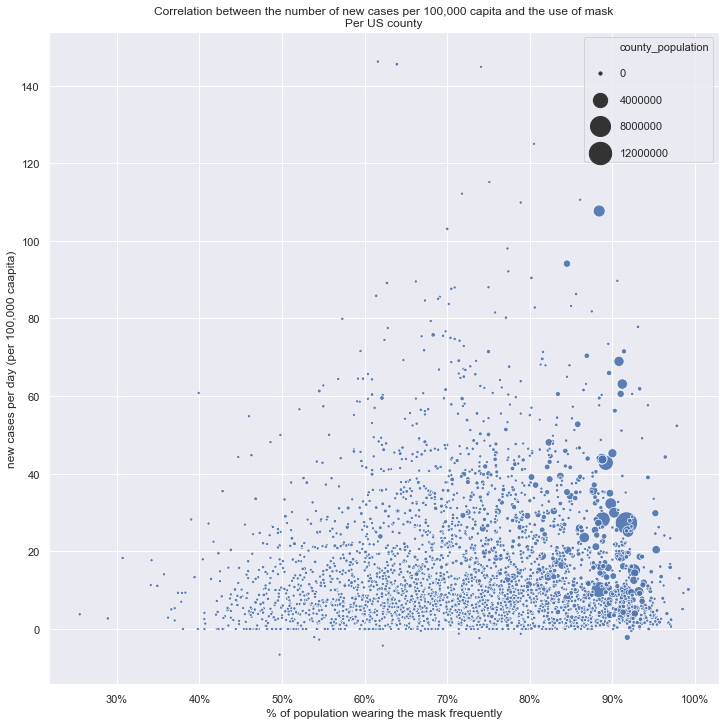

In [151]:
# Removing extreme cases
myScatterPlot(df=dfm3[dfm3.new_cases < 150], save_name=None)

TAKE-AWAY: The percentage of population wearing a mask alone do not seem to be strongly correlated to the number of new cases p.h.t.c.. in a given county. It even seems to be the opposite of my initial hypothesis as I had most probably inversed the causality. It is not because people wear the mask frequently that there are less cases. The causality is inverse: it is because there are a lot of new cases that people wear the mask frequently.

What is more visible on that data is that the most populated counties tend to have the higher propency to wear masks (big disks on the right) while having a number of new cases p.h.t.c. being equal or higher than smaller (and potentially less dense) counties.

Next step will be to study the effect of the county population density, which intuitively should be positively correlated to the number of new cases p.h.t.c..

*p.h.t.c. = per hundred thousand capita

## New Cases | Population Density

Hypothesis: The more a county has a dense population, the more new cases there should be.

In [152]:
# Import the superficie of each county
dfa = pd.read_csv('other_input/LND01-census-land-area.csv')
dfa.drop(columns='Areaname', inplace=True)
dfa.rename(columns={'STCOU': 'fips', 'LND010200D': 'county_area'}, inplace=True)
dfa.fips = convertFromTypeToStr(df=dfa.fips, from_type=np.int64)
dfa.head(3)

df converted to string


,fips,county_area
0,0,3794083.06
1,1000,52419.02
2,1001,604.45


In [163]:
# Merge are in the main df
dfm4 = dfm3.copy()
dfm4 = pd.merge(left=dfm3, right=dfa, on='fips', how='inner', left_index=True)
# dfm4

Check if some fips from the main df where not found in the county land area data:

In [156]:
nb_fips4 = len(set(dfm4.fips))
print(f'Number of fips for which we have no data in term of land area (lost when inner-merging): '\
      f'{nb_fips3 - nb_fips4}')

Number of fips for which we have no data in term of land area (lost when inner-merging): 2


In [165]:
# Identify fips that were in the main df but not found in the population data
fips_noarea = set(dfm3.fips).difference(dfm4.fips)
# Full list of fips counties that were not found in the population data
# dfm1[dfm1.fips.isin(fips_nopop)].drop_duplicates(subset=['county', 'state'])

In [166]:
# Full list of states that were not found in the county area data
set(dfm3[dfm3.fips.isin(fips_noarea)].state)

{'Alaska', 'South Dakota'}

Calculate the population density per county now:

In [167]:
# Calculate population density
dfm4['pop_density'] = dfm4.county_population / dfm4.county_area
dfm4.replace(np.inf, np.nan, inplace=True)
dfm4.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density
3036,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856
625,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540
221,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750
107,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219
210,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438


In [168]:
# Plot new cases vs population density
def pop_density_plot(df, save_name=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='pop_density', y='new_cases', size='county_population', sizes=(10, 500),
                    hue='mask_use', data=df, ax=ax, alpha=0.9)
    # ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.get_xaxis().set_label_text('county population density (people per square mile)')
    ax.get_yaxis().set_label_text('new cases per day (per 100,000 caapita)')
    ax.legend(labelspacing=1.5)
    ax.set_title('Correlation between the number of new cases per 100,000 capita '\
                 'and the population density\nPer US county')
    if save_name:
        ax.get_figure().savefig('output_visuals/' + save_name, dpi=300)

In [169]:
# pop_density_plot(df=dfm4)

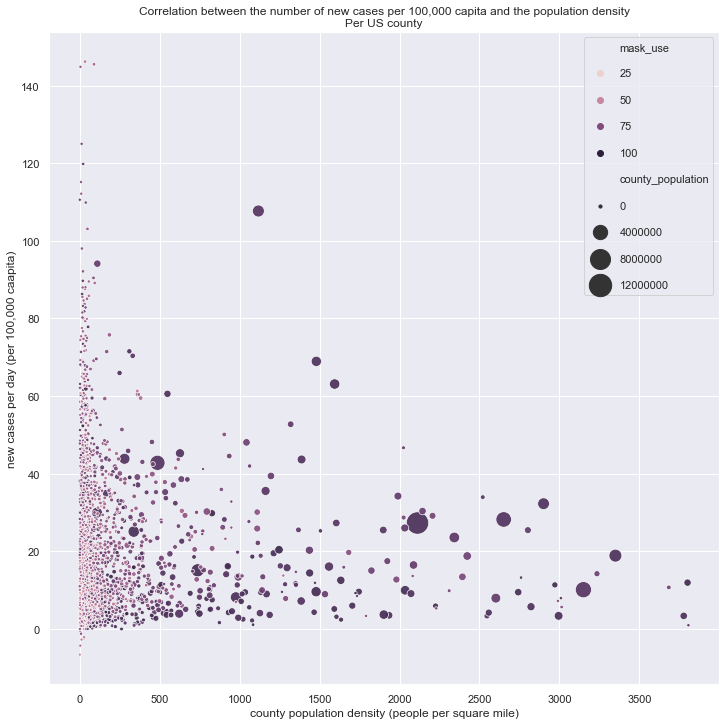

In [170]:
# Removing the extreme cases
pop_density_plot(df=dfm4[(dfm4.pop_density < 4000) & (dfm4.new_cases < 150)],
                 save_name='pop_density_dfm4.png')

TAKE-AWAY: No clear correlation in between the population density of a county and the number of daily new cases. The number of cases does not increase with the population density (which was our hypothesis). A possible explaination being that the more dense areas tend to wear the mask more (as shown by the color coding), thus curbing the effect of the population density in the spread of COVID.

## Mask-Use | Population Density

Given the prevous study, the correlation seems to be more centered around the fact that counties with higher population density tend to wear the mask more. Let's check that based on the data.

In [171]:
dfm4.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density
3036,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856
625,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540
221,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750
107,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219
210,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438


In [172]:
def pop_density_mask_plot(df, save_name=None):
    """plots the mask use correlation to population density"""
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='pop_density', y='mask_use', size='county_population', sizes=(10, 500),
#                     hue='new_cases', 
                    data=df, ax=ax, alpha=1)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.get_xaxis().set_label_text('county population density (people per square mile)')
    ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
    ax.legend(labelspacing=1.5)
    ax.set_title('Correlation between the population density '\
                 'and the use of mask\nPer US county')
    if save_name:
        ax.get_figure().savefig('output_visuals/' + save_name, dpi=300)
    return ax

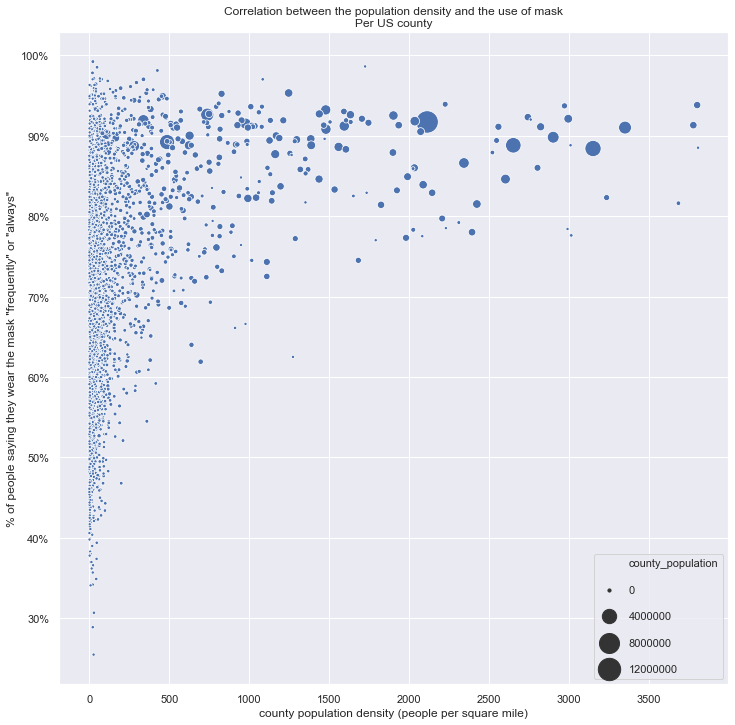

In [173]:
output_ax = pop_density_mask_plot(df=dfm4[(dfm4.pop_density < 4000) & (dfm4.new_cases < 100)], 
                     save_name='density_mask.png')

TAKE-AWAY: People living in high population density counties tend to consistently wear a mask.
People from lower density counties tend to be more distributed along the spectrum of mask usage.

## Political | Mask-Use

Gong to check if the political color of each state has an influence over its people propency to use the mask frequently.

### Get the political color of each county

In [179]:
dfp = pd.read_csv('other_input/countypres_2000-2016.csv')
dfp.drop(labels=dfp[dfp.year != 2016].index, inplace=True)
dfp.rename(columns={'FIPS': 'fips'}, inplace=True)
dfp.fips = convertFromTypeToStr(df=dfp.fips, from_type=np.float64)
dfp['party_perc'] = (dfp.candidatevotes / dfp.totalvotes) * 100
dfp.drop(labels=dfp[dfp.fips=='NA'].index, inplace=True) 
dfp2 = dfp.loc[:, ['fips', 'party', 'party_perc']].copy()
dfp2.head(2)

df converted to string


,fips,party,party_perc
40517,1001,democrat,23.769671
40518,1001,republican,72.766588


In [180]:
dfp3 = dfp2.pivot(index='fips', columns='party', values='party_perc')
dfp3.head(2)

party,NaN,democrat,republican
fips,,,
10001,5.705247,44.707633,49.587120
10003,5.315350,62.090163,32.594487


In [181]:
dfp3['maj_party'] = np.nan
dfp3.loc[dfp3[dfp3.democrat > dfp3.republican].index, 'maj_party'] = 'blue_state'
dfp3.loc[dfp3[dfp3.democrat < dfp3.republican].index, 'maj_party'] = 'red_state'
dfp3.head(2)

party,NaN,democrat,republican,maj_party
fips,,,,
10001,5.705247,44.707633,49.587120,red_state
10003,5.315350,62.090163,32.594487,blue_state


In [182]:
dfp3.drop(columns=[np.nan, 'democrat', 'republican'], inplace=True)
dfp3.head(2)

party,maj_party
fips,
10001,red_state
10003,blue_state


In [184]:
# Merge the political color in the main df
dfm5 = pd.merge(left=dfm4, right=dfp3, on='fips', how='inner', left_index=True)
dfm5.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party
2866,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856,blue_state
360,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540,blue_state
3054,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750,blue_state
1995,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219,red_state
3043,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438,blue_state


In [186]:
# Identify fips that were in the main df but not found in the political data
fips_nopol = set(dfm4.fips).difference(dfm5.fips)

In [188]:
# Full list of states that were not found in the political data
set(dfm4[dfm4.fips.isin(fips_nopol)].state)

{'Alaska'}

### Add the political color to the plot

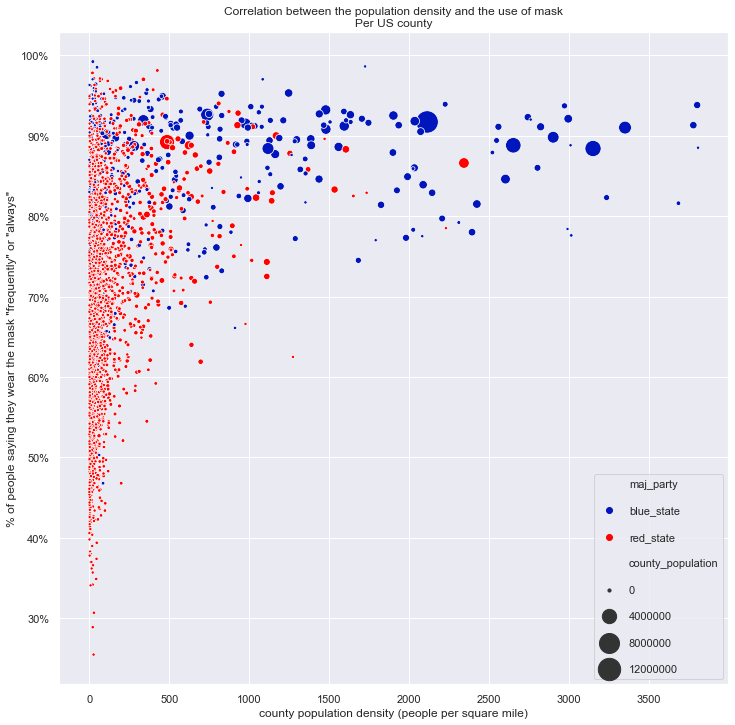

In [189]:
"""plots the mask use correlation to population density"""
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='pop_density', y='mask_use', size='county_population', sizes=(10, 500),
                hue='maj_party', 
                palette=['#0015BC', '#FF0000'],
                data=dfm5[dfm5.pop_density < 4000], 
                ax=ax, alpha=1)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('county population density (people per square mile)')
ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
ax.legend(labelspacing=1.5)
ax.set_title('Correlation between the population density '\
             'and the use of mask\nPer US county')
ax.get_figure().savefig('output_visuals/' + 'Population-density_Mask-use_Political-color.png', dpi=300)

TAKE-AWAY: The most populated counties are Blue, and tend to wear the mask more consistently.

### Represent as a boxplot

In [200]:
# Create the bins for population density
# max_dens = dfm5.pop_density.max()
# rounded_max_dens = math.ceil(max_dens / 1000) * 1000
# pop_density_steps = 500
max_density_considered = 4000
bins_buckets = np.arange(0, max_density_considered + 1, 500)
bins_buckets

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])

In [203]:
# Bucket the county population density into bins
dfm6 = dfm5.copy()
dfm6.drop(labels=dfm6[dfm6.pop_density > max_density_considered].index, inplace=True)
pop_dens_bins = pd.cut(x=dfm6.pop_density, bins=bins_buckets)
dfm6['pop_density_bins'] = pop_dens_bins
dfm6.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party,pop_density_bins
2866,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856,blue_state,"(0, 500]"
360,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540,blue_state,"(3000, 3500]"
3054,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750,blue_state,"(3000, 3500]"
1995,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219,red_state,"(0, 500]"
3043,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438,blue_state,"(2000, 2500]"


Text(0.5, 1.0, 'Correlation between the population density and the use of mask\nPer US county')

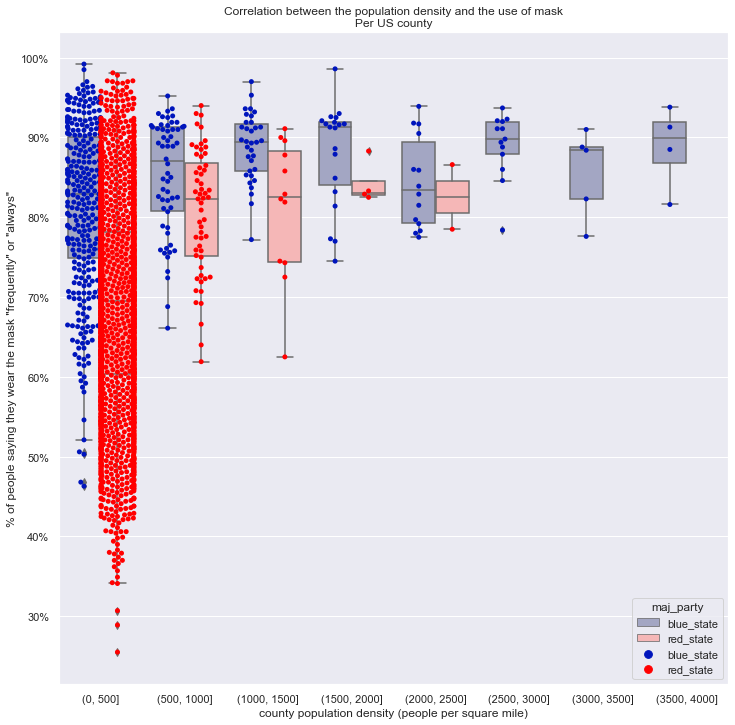

In [204]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.boxplot(x='pop_density_bins', y='mask_use', 
#             size='county_population', sizes=(10, 500),
            hue='maj_party', 
            palette=['#9da2c9', '#ffadad'],
#             palette=None,
            data=dfm6, 
            ax=ax)
sns.swarmplot(x='pop_density_bins', y='mask_use', 
#             size='county_population', sizes=(10, 500),
            hue='maj_party', 
            palette=['#0015BC', '#FF0000'],
#             palette='Reds',
            dodge=True,
            data=dfm6, 
            ax=ax)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('county population density (people per square mile)')
ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
# ax.legend(labelspacing=1.5)
ax.set_title('Correlation between the population density '\
             'and the use of mask\nPer US county')

TAKE-AWAY: Low population density counties tend to be more Repulican and to wear the mask less consistently than Democrat counties. Let's focus more on those low denity counties in the next section.

### Low population density counties

In [205]:
dfm7 = dfm6[dfm6.pop_density_bins == pd.Interval(0, 500, closed='right')].copy()
dfm7.pop_density_bins = '[0-500]'
dfm7

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party,pop_density_bins
2866,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856,blue_state,[0-500]
1995,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219,red_state,[0-500]
2942,55025,Dane,Wisconsin,50.307692,546695,9.202150,87.1,1238.32,441.481200,blue_state,[0-500]
3036,6023,Humboldt,California,3.538462,135558,2.610293,93.4,4052.22,33.452774,blue_state,[0-500]
3072,6095,Solano,California,75.461538,447643,16.857527,87.6,906.67,493.722082,blue_state,[0-500]
...,...,...,...,...,...,...,...,...,...,...,...
1398,30019,Daniels,Montana,0.000000,1690,0.000000,39.8,1426.52,1.184701,red_state,[0-500]
1536,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0,575.57,1.360391,red_state,[0-500]
2883,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7,320.48,26.360459,red_state,[0-500]
2611,49055,Wayne,Utah,0.000000,2711,0.000000,68.9,2466.47,1.099142,red_state,[0-500]


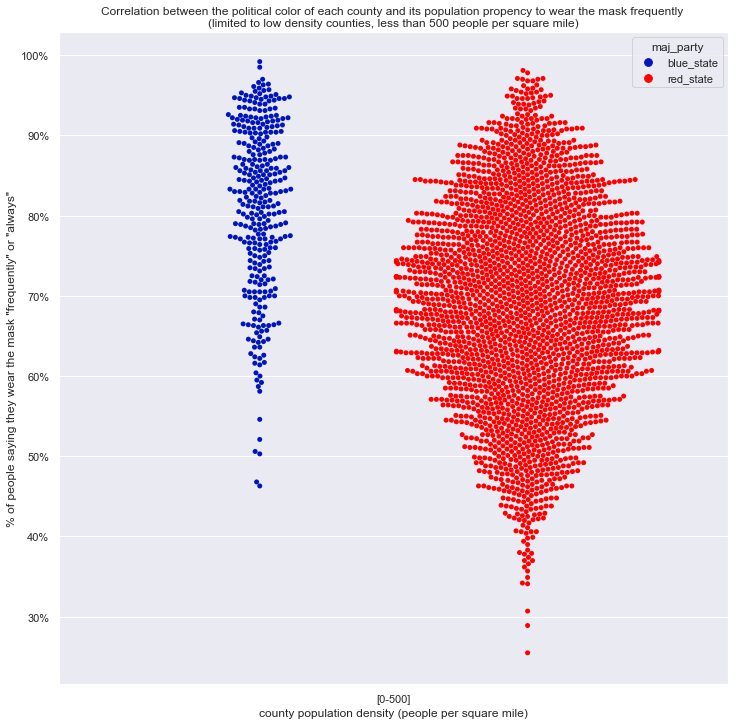

In [207]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.swarmplot(x='pop_density_bins', y='mask_use', 
            hue='maj_party', 
            palette=['#0015BC', '#FF0000'],
            dodge=True,
            data=dfm7, 
            ax=ax)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('county population density (people per square mile)')
ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
# ax.legend(labelspacing=1.5)
ax.set_title('Correlation between the political color of each county and its '\
             'population propency to wear'\
             ' the mask frequently \n(limited to low density counties, less than '\
             '500 people per square mile)')
ax.get_figure().savefig('output_visuals/' + 'Mask-use_Political_light-dens-co9unties.png', dpi=300)

TAKE-AWAY: In light population density counties (0 to 500 habitants per square mile), people are wearing the mask significantly more frequently in the democrat counties (compared to the republican counties).

## Shame Counties

Counties with low use of mask, and high number of daily new cases.

In [208]:
dfm7[(dfm7.mask_use < 50) & (dfm7.new_cases > 40)]

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party,pop_density_bins
2255,47041,DeKalb,Tennessee,11.230769,20490,54.810977,46.0,328.98,62.283421,red_state,[0-500]
16,1027,Clay,Alabama,6.615385,13235,49.984017,49.8,606.00,21.839934,red_state,[0-500]
632,19187,Webster,Iowa,16.076923,35904,44.777526,46.3,718.05,50.002089,red_state,[0-500]
573,19069,Franklin,Iowa,4.461538,10070,44.305248,44.7,583.01,17.272431,red_state,[0-500]
2254,47039,Decatur,Tennessee,5.615385,11663,48.147000,48.6,344.91,33.814618,red_state,[0-500]
1784,38005,Benson,North Dakota,4.153846,6832,60.799856,39.9,1439.27,4.746851,red_state,[0-500]


Counties with low mask-use (<50%), still having a way abover average number of new cases (> 40 new cases per day per 100,000 habitants, when the mean is 16)

## Mask-Use | Percentage of total population

In [215]:
dfm7 = dfm3.copy()
dfm7['pop_perc'] = (dfm7.county_population / dfm7.county_population.sum()) * 100
dfm7.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,pop_perc
0,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,0.257033
1,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1.610278
2,6059,Orange,California,600.153846,3175692,18.898364,91.0,0.992916
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,1.402415
4,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,3.138840


In [217]:
# Create mask-use buckets
mask_use_bins = np.arange(20, 110, 10)
dfm7['mask_use_buckets'] = pd.cut(x=dfm7.mask_use, bins=mask_use_bins)
dfm7.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,pop_perc,mask_use_buckets
0,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,0.257033,"(90, 100]"
1,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1.610278,"(80, 90]"
2,6059,Orange,California,600.153846,3175692,18.898364,91.0,0.992916,"(90, 100]"
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,1.402415,"(80, 90]"
4,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,3.138840,"(90, 100]"


In [219]:
dfm7s = dfm7.loc[:, ['mask_use_buckets', 'pop_perc']]
dfm7s.head()

,mask_use_buckets,pop_perc
0,"(90, 100]",0.257033
1,"(80, 90]",1.610278
2,"(90, 100]",0.992916
3,"(80, 90]",1.402415
4,"(90, 100]",3.138840


In [220]:
dfm7sg = dfm7s.groupby(by='mask_use_buckets').sum()
dfm7sg.head()

,pop_perc
mask_use_buckets,
"(20, 30]",0.013659
"(30, 40]",0.073255
"(40, 50]",0.880558
"(50, 60]",3.187771
"(60, 70]",8.362238


Text(0.5, 1.0, 'Breakdown of the US population per frequent mask-use %')

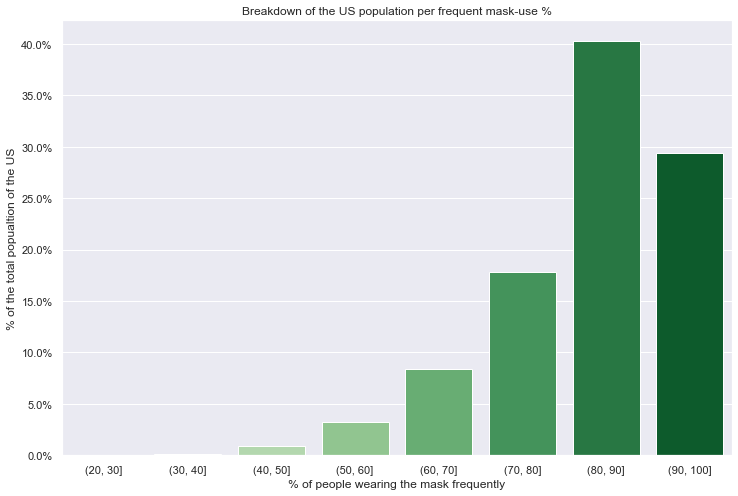

In [221]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=dfm7sg.index.values, y=dfm7sg.pop_perc, palette='Greens')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('% of people wearing the mask frequently')
ax.get_yaxis().set_label_text('% of the total popualtion of the US')
ax.set_title('Breakdown of the US population per frequent mask-use %')
# ax.get_figure().savefig('output_visuals/' + 'Mask-use_Political_light-dens-co9unties.png', dpi=300)

## Sates ranked per number of cases

In [288]:
last_timestamp = df.index.sort_values()[-1]

In [289]:

df[last_timestamp:].sort_values(by='cases',ascending=False).head(10)

,date,state,fips,cases,deaths,Abbreviation,Postal Code
8153,2020-07-28,Northern Mariana Islands,69,40,2,NaN,NaN


In [290]:
df_summary = df.loc[last_timestamp:, ['cases', 'deaths']].sum().copy()
df_summary.index.values

array(['cases', 'deaths'], dtype=object)

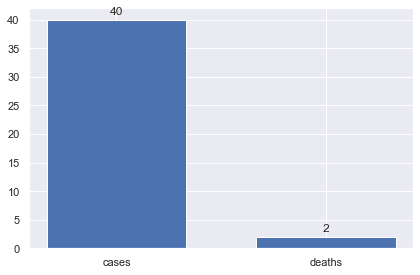

In [291]:
fig, ax = plt.subplots()
rects = ax.bar(x=[0, 0.3], height=df_summary.values, width=0.2, tick_label=df_summary.index.values)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,p: format(int(x),',')))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)

fig.tight_layout()


### Mortality rate

In [292]:
df_summary['deaths'] / df_summary['cases']

0.05

## Number of New Cases per day (for a list of states)

In [293]:
dft = df.copy()
# Make it a time series
dft.set_index(keys='date', drop=True, inplace=True)
dft

,state,fips,cases,deaths,Abbreviation,Postal Code
date,,,,,,
2020-01-21,Washington,53,1,0,Wash.,WA
2020-01-22,Washington,53,1,0,Wash.,WA
2020-01-23,Washington,53,1,0,Wash.,WA
2020-01-24,Washington,53,1,0,Wash.,WA
2020-01-25,Washington,53,1,0,Wash.,WA
...,...,...,...,...,...,...
2020-07-24,Northern Mariana Islands,69,38,2,NaN,NaN
2020-07-25,Northern Mariana Islands,69,40,2,NaN,NaN
2020-07-26,Northern Mariana Islands,69,40,2,NaN,NaN


In [294]:
states_list = ["New York","New Jersey","California","Michigan","Massachusetts","Florida","Washington","Illinois","Pennsylvania","Louisiana", "Texas"]
len(states_list)

11

In [295]:
df_states_list = []
# Iterate over all states, create the df and append to the list
for i,state in enumerate(states_list):
    # create a local copy of the df
    df_state = dft[dft.state == state].copy()
    # calculate the number of new cases per day
    df_state['new cases'] = df_state['cases'] - df_state['cases'].shift(1)
    df_state.fillna(0,inplace=True)
    # calculate SMA
    df_state['SMA'] = ( df_state['new cases'] + df_state['new cases'].shift(1) + df_state['new cases'].shift(2) )*1/3
    # append the df of that state to the list
    df_states_list.append(df_state)

In [296]:
df_states_list[10]

,state,fips,cases,deaths,Abbreviation,Postal Code,new cases,SMA
date,,,,,,,,
2020-02-12,Texas,48,1,0,Tex.,TX,0.0,NaN
2020-02-13,Texas,48,2,0,Tex.,TX,1.0,NaN
2020-02-14,Texas,48,2,0,Tex.,TX,0.0,0.333333
2020-02-15,Texas,48,2,0,Tex.,TX,0.0,0.333333
2020-02-16,Texas,48,2,0,Tex.,TX,0.0,0.000000
...,...,...,...,...,...,...,...,...
2020-07-24,Texas,48,383662,4876,Tex.,TX,7558.0,9356.000000
2020-07-25,Texas,48,391609,5002,Tex.,TX,7947.0,8349.333333
2020-07-26,Texas,48,395738,5090,Tex.,TX,4129.0,6544.666667


### PLOT OF NEW CASES (for the 4 most impacted states)

In [297]:
def my_new_cases_plotter(df_list,states_list):

    nb_columns_fig = 2
    nb_rows_fig = 6
    
    fig, ax_arr = plt.subplots(nb_rows_fig, nb_columns_fig)  # create a figure with a 'rows x columns' grid of axes
    fig.set_size_inches(16,24)
    fig.suptitle("New cases registered per day")
    
    for df_index in range(len(df_list)):  # iterate over all the data frames to plot
    
        i_fig = int((np.floor(df_index / nb_columns_fig)))  # row position of the axes on that given figure
        j_fig = int((df_index % nb_columns_fig))  # column position of the axes on that given figure

        df = df_list[df_index].loc['20200301':]  # df to plot at that position

        ax_arr[i_fig,j_fig].bar(x=df['new cases'].index,height=df['new cases'],color="#900C3F")
        ax_arr[i_fig,j_fig].plot(df['new cases'].index,df['SMA'],color="#FFC300")

        ax_arr[i_fig,j_fig].xaxis.set_major_locator(WeekdayLocator(MONDAY))
#         ax_arr[i_fig,j_fig].xaxis.set_minor_locator(DayLocator())
        ax_arr[i_fig,j_fig].xaxis.set_major_formatter(DateFormatter('%d'))
#         ax_arr[i_fig,j_fig].xaxis.set_minor_formatter(DateFormatter('%d'))
        ax_arr[i_fig,j_fig].set_title(states_list[df_index])
    return fig
        

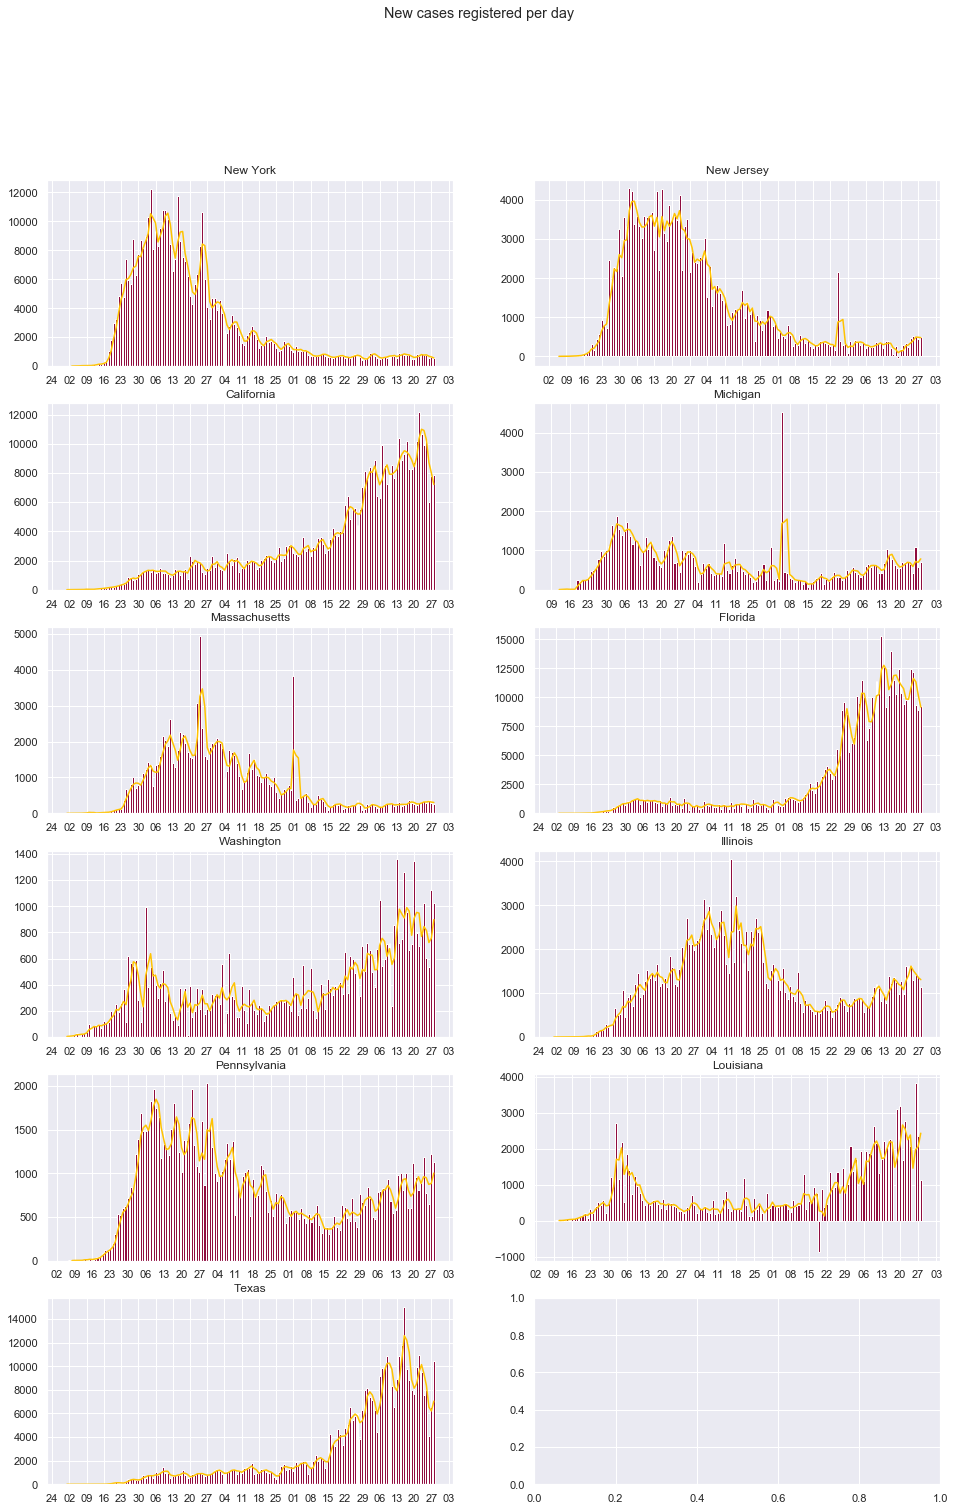

In [298]:
fig = my_new_cases_plotter(df_states_list,states_list)

In [299]:
# fig.savefig('covid_per_US_state.png')